BASES NT

Concatenação das bases de dados

In [165]:
import pandas as pd
import pandas

# Carrega os DataFrames dos arquivos Excel de 2022 e 2023
df22 = pd.read_excel('c:\\Users\\caiobarreto\\Downloads\\Relatório_NT_2022.xlsx')
df23 = pd.read_excel('c:\\Users\\caiobarreto\\Downloads\\Relatório_NT_2023.xlsx')
# Concatena os DataFrames
df = pd.concat([df22, df23])
# Define o caminho do arquivo de saída para o DataFrame concatenado
saida = 'c:\\Users\\caiobarreto\\Downloads\\Relatório_NT_Concatenado.xlsx'
# Salva o DataFrame concatenado em um novo arquivo Excel
df.to_excel(saida, index=False)

Retirar acentos e ç

In [166]:
from unidecode import unidecode

# Remover acentos e caracteres especiais de todas as colunas
df = df.apply(lambda x: x.map(lambda y: unidecode(str(y)) if isinstance(y, str) else y))

 Ele utiliza a função apply para aplicar uma função lambda a cada coluna do DataFrame, e dentro dessa função lambda, utiliza outra função lambda para percorrer cada valor da coluna e remover a acentuação, caso o valor seja uma string.

Padronizar formato de data e hora

In [167]:
# Padronizar o formato de data e hora
formatar = ['Data Prevista de Chegada', 'Data Prevista de Saída', 
'H.O.C.', 'Amarração','Início de Bombeio', 'Fim de Bombeio', 'Desamarração', 'H.O.S.', 'Início Primeira Amarração','Fim Primeira Amarração','Início Primeira Conexão','Fim Primeira Conexão',
'Início Primeiro Bombeio','Fim Último Bombeio','Início Última Desconexão','Fim Última Desconexão','Início Última Desamarração','Fim Última Desamarração']

for coluna in formatar:
    df[coluna] = pandas.to_datetime(df[coluna], dayfirst=True)

Remover colunas

In [168]:
# Removendo as colunas, inplace é pra não precisar reatribuir e axis 1 serve pra dizer que se trata de uma coluna
df.drop(['Classe do Navio', 'Rebocador', 'Hora Top', 'Alívio Crítico', 'Apuração Alívio Crítico', 'Volume Acumulado Perdas', 'Lifter'], inplace=True, axis=1)

Tirar duplicatas

In [169]:
# Remove as duplicatas
df=df.drop_duplicates()

Adicionando coluna ID e adicionando valor ao indice

In [170]:
# Redefinir o índice do DataFrame
df.reset_index(drop=True, inplace=True)
# Adicionando a coluna
df.insert(0,'ID',range(len(df)))

Criando coluna UEP e trocando Petrobras por P-

In [171]:
# Adicionando a coluna UEP e pegando o valor da coluna Instalação Naval
df.insert(2, 'UEP', df['Instalação Naval'].str.replace('PETROBRAS', 'P-', regex=True))

Retirar os espaços em branco antes e no fim das colunas UEP e Navio

In [172]:
# Remover espaços em branco antes e depois dos nomes nas colunas UEP e Navio
df['UEP'] = df['UEP'].str.strip()
df['Navio'] = df['Navio'].str.strip()

Transformar H.O.C em data prevista de chegada quando a diferença for >= 48 horas

In [173]:
# Calculando a diferença em horas entre as datas previstas de chegada e o H.O.C
diferenca_horas = (df['Data Prevista de Chegada'] - df['H.O.C.']).dt.total_seconds() / 3600

# Substituindo os valores de "H.O.C" onde a diferença for maior do que 48 horas (2 dias)
df.loc[diferenca_horas >= 48, 'H.O.C.'] = df['Data Prevista de Chegada']

Tirar duplicatas dos casos que possuem mesmo HOC, Instalação Naval e Navio

In [174]:
# Remover duplicatas baseadas em "H.O.C", "Instalação Naval" e "Navio"
df.drop_duplicates(subset=['H.O.C.', 'Instalação Naval', 'Navio'], inplace=True)

ALTERANDO O FORMATO DA BASE

In [175]:
# Selecionar apenas as colunas necessárias para alteração no formato do dataframe
nt_colunas = ['ID', 'H.O.C.', 'Início Primeira Amarração', 'Fim Primeira Amarração', 'Início Primeira Conexão', 'Fim Primeira Conexão', 'Início Primeiro Bombeio','Fim Último Bombeio', 'Início Última Desconexão', 'Fim Última Desconexão','Início Última Desamarração', 'Fim Última Desamarração', 'H.O.S.']

# Selecionar e definir as colunas que serão alteradas
colunas_alteradas = ['H.O.C.', 'Início Primeira Amarração', 'Fim Primeira Amarração','Início Primeira Conexão', 'Fim Primeira Conexão', 'Início Primeiro Bombeio','Fim Último Bombeio', 'Início Última Desconexão', 'Fim Última Desconexão','Início Última Desconexão', 'Fim Última Desconexão', 'Início Última Desamarração','Fim Última Desamarração', 'H.O.S.']
# Usar o método melt para transformar as colunas em registros
df_transformado = pd.melt(df[nt_colunas], id_vars=['ID'], value_vars=colunas_alteradas, var_name='Ocorrência', value_name='Data')
# Selecionar apenas as colunas necessárias para a junção
colunas_restauradas = ['ID', 'Unidade Operativa', 'UEP', 'Navio', 'Volume Programado','Volume Retirado', 'Viagem', 'Destino', 'Data Prevista de Chegada','Data Prevista de Saída']
# Realizar a junção dos DataFrames usando a coluna 'ID' como chave
df_final = pd.merge(df[colunas_restauradas], df_transformado, on='ID', how='right')


pd.melt() é usado para transformar as colunas selecionadas em registros. O argumento id_vars=['ID'] indica quais colunas manter como identificadores, enquanto value_vars=colunas_alteradas especifica quais colunas devem ser transformadas em registros. As colunas "Ocorrência" e "Data" são os nomes das novas colunas geradas durante a transformação.

Ordenar a base por ID e Data

In [176]:
# Ordenar o DataFrame final por 'ID' e 'Data'
df_final = df_final.sort_values(by=['ID', 'Data'])

Adicionar os respectivos valores às colunas ‘Início’ e ‘Término’ de cada ocorrência

In [177]:
# Adicionar as colunas 'Início' e 'Término' com base nas datas da ocorrência e da próxima ocorrência para o mesmo ID
df_final['Início'] = df_final['Data']
# Obter o valor da próxima linha na coluna "Início"
df_final['Término'] = df_final['Início'].shift(-1)

Excluir as colunas com “Ocorrência” = ”Fim”

In [178]:
# Filtrar as linhas em que a "Ocorrência" contém a palavra "Fim" e obter seus índices
indices_para_remover = df_final[df_final['Ocorrência'].str.contains('Fim')].index
# Remover as linhas correspondentes aos índices obtidos
df_final.drop(indices_para_remover, inplace=True)

Renomear as colunas

In [179]:
# Retirar a palavra Início da ocorrência
df_final['Ocorrência'] = df_final['Ocorrência'].str.replace('Início ', '')
df_final['Ocorrência'] = df_final['Ocorrência'].str.replace('Última ', '')
df_final['Ocorrência'] = df_final['Ocorrência'].str.replace('Primeiro ', '')
df_final['Ocorrência'] = df_final['Ocorrência'].str.replace('Primeira ', '')

Remover a coluna data

In [180]:
# Removendo as colunas, inplace é pra não precisar reatribuir e axis 1 serve pra dizer que se trata de uma coluna
df_final.drop(['Data'],inplace=True, axis=1)

BASE INTERRUPÇÕES

Importar Base Interrupções

In [181]:
dfInt = pd.read_excel("c:\\Users\\caiobarreto\\Downloads\\eventos_operacoes_interrupcoes2.xlsx")

Filtrar somente as que tiveram interrupções

In [182]:
# Filtrar apenas as linhas em que 'Duração Interrupção' é maior que zero e reatribuir ao DataFrame dfInt
dfInt = dfInt[dfInt['Duração Interrupção'] > 0]

Retirando Acento e Ç

In [183]:
dfInt = dfInt.apply(lambda x: x.map(lambda y: unidecode(str(y)) if isinstance(y, str) else y))

Criando coluna UEP

In [184]:
# Adicionando a coluna UEP 
dfInt.insert(2, 'UEP', dfInt['INNA_SG_INSTALACAO_NAVAL'].str.replace('PETROBRAS', 'P-', regex=True))

Alterando nomes das categorias da coluna UEP

In [185]:
# Faz um dicionário com os nomes a serem mudados na UEP
trocaNomes = {
    'FPBAR': 'FPSO Almirante Barroso',
    'FPCGZ': 'FPSO Campos dos Goytacases MV29',
    'CAPX': 'FPSO Capixaba',
    'FPCRC': 'FPSO CARIOCA MV30',
    'FPNIT': 'FPSO Cid. Niteroi MV18',
    'CDAN': 'FPSO Cidade de Anchieta',
    'FPCAR': 'FPSO Cidade de Angra Reis MV22',
    'FPCIB': 'FPSO Cidade de Ilhabela',
    'FPCMB': 'FPSO Cidade de Mangaratiba MV24',
    'FPCIG': 'FPSO Cidade de Itaguai MV26',
    'FPCMC': 'FPSO Cidade de Marica',
    'FPCPY': 'FPSO Cidade de Paraty',
    'FPCST': 'FPSO Cidade de Santos MV20',
    'FPCSQ': 'FPSO Cidade de Saquarema',
    'FPCSP': 'FPSO Cidade Sao Paulo MV23',
    'FPGNB': 'FPSO Guanabara - MV31',
    'FPPLB': 'FPSO Pioneiro de Libra',
    'FSME': 'FSO Cidade de Macae - MV15'
}

# Faz a troca dos nomes da UEP utilizando o replace
dfInt['UEP'] = dfInt['UEP'].replace(trocaNomes)

Renomear as colunas para ficar com a mesma nomenclatura que a base NT

In [186]:
# Definindo o dicionário para renomear as colunas
nomeColunas = {
    'OPOF_CD_VIAGEM': 'Viagem',
    'OPOF_NM_NAVIO': 'Navio',
    'OPOF_NM_DESTINO': 'Destino',
    'EOOF_IN_TIPO': 'TIPO_INTERRUPCAO',
    'Duração Interrupção': 'DURACAO_INTERRUPCAO',
    'EOOF_DT_REALIZADA': 'INICIO_INTERRUPCAO',
    'EOOF_DT_FIM': 'FIM_INTERRUPCAO',
    'OPOF_DT_ENTRADA_PREVISTA': 'Data Prevista de Chegada',
    'OPOF_DT_SAIDA_PREVISTA': 'Data Prevista de Saída'
}

# Renomeando as colunas conforme o dicionário 
dfInt.rename(columns=nomeColunas, inplace=True)

Retirar o espaço do inicio e final das colunas Navio e UEP

In [187]:
# Remover espaços em branco antes e depois dos nomes nas colunas UEP e Navio
dfInt['UEP'] = dfInt['UEP'].str.strip()
dfInt['Navio'] = dfInt['Navio'].str.strip()

Selecionar apenas as colunas que interessam

In [188]:
# Selecionar apenas as colunas necessárias do DataFrame dfInt
colunasSel = dfInt[['UEP', 'Viagem', 'Navio', 'Destino', 'TIPO_INTERRUPCAO', 'DURACAO_INTERRUPCAO', 'INICIO_INTERRUPCAO', 'FIM_INTERRUPCAO', 'Data Prevista de Chegada', 'Data Prevista de Saída']]

JUNTAR BASE DE INTERRUPÇÕES COM A DE NAVIO TANQUE

In [189]:
# Junção das bases de interrupções e NT
dfUni = pd.merge(df_final, colunasSel, on=['UEP', 'Viagem', 'Navio', 'Destino', 'Data Prevista de Chegada', 'Data Prevista de Saída'], how='left')
dfUni

,ID,Unidade Operativa,UEP,Navio,Volume Programado,Volume Retirado,Viagem,Destino,Data Prevista de Chegada,Data Prevista de Saída,Ocorrência,Início,Término,TIPO_INTERRUPCAO,DURACAO_INTERRUPCAO,INICIO_INTERRUPCAO,FIM_INTERRUPCAO
0,0,UN-BS,P- 67,FORTALEZA KNUTSEN,80000,81382.81,423 TA,T.B.N.,2022-04-27 12:00:00,2022-04-28 09:30:00,H.O.C.,2022-04-27 03:00:00,2022-04-27 09:04:00,NaN,NaN,NaT,NaT
1,0,UN-BS,P- 67,FORTALEZA KNUTSEN,80000,81382.81,423 TA,T.B.N.,2022-04-27 12:00:00,2022-04-28 09:30:00,Primeira Amarração,2022-04-27 09:04:00,2022-04-27 09:35:00,NaN,NaN,NaT,NaT
2,0,UN-BS,P- 67,FORTALEZA KNUTSEN,80000,81382.81,423 TA,T.B.N.,2022-04-27 12:00:00,2022-04-28 09:30:00,Primeira Conexão,2022-04-27 09:40:00,2022-04-27 10:11:00,NaN,NaN,NaT,NaT
3,0,UN-BS,P- 67,FORTALEZA KNUTSEN,80000,81382.81,423 TA,T.B.N.,2022-04-27 12:00:00,2022-04-28 09:30:00,Primeiro Bombeio,2022-04-27 12:00:00,2022-04-28 07:00:00,NaN,NaN,NaT,NaT
4,0,UN-BS,P- 67,FORTALEZA KNUTSEN,80000,81382.81,423 TA,T.B.N.,2022-04-27 12:00:00,2022-04-28 09:30:00,Última Desconexão,2022-04-28 08:30:00,2022-04-28 08:55:00,NaN,NaN,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22661,3225,UN-BUZ,P- 76,ELKA LEBLON,80000,81372.15,402 TA,T.B.N.,2023-07-31 13:00:00,2023-08-01 18:00:00,Primeira Conexão,2023-07-31 16:30:00,2023-07-31 17:48:00,NaN,NaN,NaT,NaT
22662,3225,UN-BUZ,P- 76,ELKA LEBLON,80000,81372.15,402 TA,T.B.N.,2023-07-31 13:00:00,2023-08-01 18:00:00,Primeiro Bombeio,2023-07-31 19:06:00,2023-08-01 12:42:00,NaN,NaN,NaT,NaT
22663,3225,UN-BUZ,P- 76,ELKA LEBLON,80000,81372.15,402 TA,T.B.N.,2023-07-31 13:00:00,2023-08-01 18:00:00,Última Desconexão,2023-08-01 14:48:00,2023-08-01 15:36:00,NaN,NaN,NaT,NaT
22664,3225,UN-BUZ,P- 76,ELKA LEBLON,80000,81372.15,402 TA,T.B.N.,2023-07-31 13:00:00,2023-08-01 18:00:00,Última Desamarração,2023-08-01 15:37:00,2023-08-01 16:12:00,NaN,NaN,NaT,NaT


Restringir as características de interrupção apenas aos bombeios

In [190]:
# Substituir valor da coluna 'TIPO_INTERRUPCAO' por 'Interrupção Bombeio' onde 'Ocorrência' contém 'Bombeio' e 'TIPO_INTERRUPCAO' = 'B005', caso contrário, substituir por ''
condicao_1 = (dfUni['Ocorrência'].str.contains('Bombeio')) & (dfUni['TIPO_INTERRUPCAO'] == 'B005')
dfUni.loc[condicao_1, 'TIPO_INTERRUPCAO'] = 'Interrupção Bombeio'
dfUni.loc[~condicao_1, 'TIPO_INTERRUPCAO'] = ''

# Manter valor da coluna 'DURACAO_INTERRUPCAO' onde 'Ocorrência' contém 'Bombeio' e 'DURACAO_INTERRUPCAO' > 0
condicao_2 = (dfUni['Ocorrência'].str.contains('Bombeio')) & (dfUni['DURACAO_INTERRUPCAO'] > 0)
dfUni.loc[condicao_2, 'DURACAO_INTERRUPCAO'] = dfUni.loc[condicao_2, 'DURACAO_INTERRUPCAO']
dfUni.loc[~condicao_2, 'TIPO_INTERRUPCAO'] = ''

# Manter valor da coluna 'INICIO_INTERRUPCAO' onde 'Ocorrência' contém 'Bombeio' e 'TIPO_INTERRUPCAO' = 'Interrupção Bombeio'
condicao_3 = (dfUni['Ocorrência'].str.contains('Bombeio')) & (dfUni['TIPO_INTERRUPCAO'] == 'Interrupção Bombeio')
dfUni.loc[condicao_3, 'INICIO_INTERRUPCAO'] = dfUni.loc[condicao_3, 'INICIO_INTERRUPCAO']
dfUni.loc[~condicao_3, 'TIPO_INTERRUPCAO'] = ''

# Manter valor da coluna 'FIM_INTERRUPCAO' onde 'Ocorrência' contém 'Bombeio' e 'TIPO_INTERRUPCAO' = 'Interrupção Bombeio'
condicao_4 = (dfUni['Ocorrência'].str.contains('Bombeio')) & (dfUni['TIPO_INTERRUPCAO'] == 'Interrupção Bombeio')
dfUni.loc[condicao_4, 'FIM_INTERRUPCAO'] = dfUni.loc[condicao_4, 'FIM_INTERRUPCAO']
dfUni.loc[~condicao_4, 'TIPO_INTERRUPCAO'] = ''

Duplicas as linhas em que acontece as interrupções e resetar os índices

In [191]:
df_filtered = dfUni[dfUni['TIPO_INTERRUPCAO'].notna()]
df_resultado = pandas.concat([dfUni, df_filtered], ignore_index=True)
df_resultado.reset_index(drop=True, inplace=True)
lista_remover = []
for i, row in df_resultado.iterrows():
    if i < len(df_resultado)-2:
        linha_atual = df_resultado.iloc[i]
        linha_seguinte = df_resultado.iloc[i+1]
        linha_seguinte_seguinte = df_resultado.iloc[i+2]
        if ((linha_atual['ID'] == linha_seguinte['ID'] and linha_atual['TIPO_INTERRUPCAO'] == "Interrupção Bombeio")) and ((linha_seguinte['ID'] == linha_seguinte_seguinte['ID'] and linha_seguinte['TIPO_INTERRUPCAO'] == "Interrupção Bombeio")):
            lista_remover.append(linha_seguinte_seguinte.name)

Ordenar por ID e Início

In [192]:
# Ordenar por ID e início
df_resultado.sort_values(by=['ID', 'Início','INICIO_INTERRUPCAO'], inplace=True)

Se o inicio da interrupção for antes do bombeio, substituir o valor de inicio da interrupção pelo valor de inicio do bombeio, o mesmo acontece para as datas de fim, se o fim da interrupção for depois do fim do bombeio, substituir o fim da interrupção com o valor de fim do bombeio

In [193]:
import numpy as np

# Verificar se TIPO_INTERRUPCAO está vazio e substituir os valores das outras colunas
condicao = df_resultado['TIPO_INTERRUPCAO'] == ''
df_resultado.loc[condicao, ['DURACAO_INTERRUPCAO', 'INICIO_INTERRUPCAO', 'FIM_INTERRUPCAO']] = np.nan

# Substituir o início da interrupção pelo valor de início do bombeio onde necessário
df_resultado.loc[df_resultado['INICIO_INTERRUPCAO'] < df_resultado['Início'], 'INICIO_INTERRUPCAO'] = df_resultado['Início']

# Substituir o fim da interrupção pelo valor de fim do bombeio onde necessário
df_resultado.loc[df_resultado['FIM_INTERRUPCAO'] > df_resultado['Término'], 'FIM_INTERRUPCAO'] = df_resultado['Término']


Alterar as datas de término da primeira interrupção e início da segunda interrupção dentro de um mesmo id

In [194]:
# Verificar se TIPO_INTERRUPCAO de linhas consecutivas são iguais a "Interrupção Bombeio"
condicao_1 = (df_resultado['TIPO_INTERRUPCAO'].shift() == 'Interrupção Bombeio') & (df_resultado['TIPO_INTERRUPCAO'] == 'Interrupção Bombeio')
# Verificar se DURACAO_INTERRUPCAO de linhas consecutivas são diferentes
condicao_2 = (df_resultado['TIPO_INTERRUPCAO'].shift() == 'Interrupção Bombeio') & (df_resultado['TIPO_INTERRUPCAO'] == 'Interrupção Bombeio') & (df_resultado['DURACAO_INTERRUPCAO'].shift() != df_resultado['DURACAO_INTERRUPCAO'])
# Atualizar as datas conforme as condições especificadas
df_resultado.loc[condicao_1, 'Término'] = df_resultado['INICIO_INTERRUPCAO'].shift(-1)
df_resultado.loc[condicao_1, 'Início'] = df_resultado['FIM_INTERRUPCAO']
df_resultado.loc[condicao_2, 'Início'] = df_resultado['FIM_INTERRUPCAO']

Retirar os casos com bombeio instantâneo

In [195]:
for indice,linha in df_resultado.iterrows():
    if linha['Início'] == linha['Término']:
       df_resultado.drop(index=indice)

Para a ocorrência H.O.S. trocar os términos que estão vazios pelos inícios, pois o H.O.S. é sempre 
instantâneo

In [ ]:
# - Para a ocorrência H.O.S. trocar os términos que estão vazios pelos inícios, pois o H.O.S. é sempre instantâneo.
for index,linha in df_resultado.iterrows():
    if linha['Ocorrência'] == "H.O.S.":
        if type(df_resultado['Término'][index]) == pd._libs.tslibs.nattype.NaTType:
            df_resultado['Término'][index] = df_resultado["Início"][index]

Describe de cada DataFrame

In [197]:
#Base concatenada de navios tanque dos anos 2022 e 2023
df_final.describe()

,ID,Volume Programado,Volume Retirado,Data Prevista de Chegada,Data Prevista de Saída,Início,Término
count,22547.000000,22547.000000,22547.000000,22547,22547,22547,22546
mean,1610.828004,80736.260168,80271.148486,2022-10-16 05:22:29.694504960,2022-10-17 15:29:23.174169344,2022-10-16 22:45:40.688339968,2022-10-16 22:07:02.687838208
min,0.000000,2000.000000,1990.100000,2022-01-01 00:01:00,2022-01-01 23:30:00,2022-01-01 00:01:00,2022-01-01 00:01:00
25%,805.000000,70000.000000,70096.180000,2022-05-24 00:00:00,2022-05-25 12:10:00,2022-05-24 16:35:00,2022-05-24 16:11:45
50%,1610.000000,79400.000000,78946.000000,2022-10-14 00:00:00,2022-10-15 09:34:00,2022-10-14 23:18:00,2022-10-14 22:58:30
75%,2416.000000,86000.000000,85689.250000,2023-03-08 13:00:00,2023-03-09 23:39:34,2023-03-09 11:15:00,2023-03-09 10:23:00
max,3225.000000,166000.000000,170507.000000,2023-07-31 13:00:00,2023-08-01 18:00:00,2023-08-01 18:00:00,2023-08-01 16:48:00
std,930.762839,30074.616378,30273.130499,NaN,NaN,NaN,NaN


In [198]:
#Base de interrupções
dfInt.describe()

,EOOF_SQ_EVENTO_OPER_OFFLOAD,OPOF_SQ_OPERACAO,DURACAO_INTERRUPCAO,INICIO_INTERRUPCAO,FIM_INTERRUPCAO,MEOF_SQ_MOTIVO_EVENT_OFFLOAD,EOOF_NM_ARQUIVO_ARMAZENAMENTO,OPOF_SQ_OPERACAO_1,Data Prevista de Chegada,Data Prevista de Saída,...,OPOF_TX_OBSERVACAO,OPOF_SQ_OPERACAO_ANTERIOR,INNA_SQ_INSTALACAO_NAVAL,OPOF_DT_ATUALIZACAO,OPOS_SQ_OPERACAO,OPOF_VL_VAZAO_NV_ALIVIADOR,OPOF_IN_FAIXA_VAZAO_NV_ALIV,OPOF_DT_CADASTRO,OPOF_DT_TOP,OPOF_DS_DIRECAO_VENTO
count,414.000000,414.000000,414.000000,414,414,414.000000,0.0,414.000000,414,414,...,0.0,0.0,414.000000,337,337.000000,0.0,0.0,414,414,90.000000
mean,81346.437198,10667.157005,4.809219,2022-10-06 14:55:30.869565184,2022-10-06 19:44:04.057970688,13.797101,NaN,10667.157005,2022-10-05 15:21:19.855072512,2022-10-07 13:50:13.644927744,...,NaN,NaN,309.362319,2022-10-04 06:13:51.869436160,14413.753709,NaN,NaN,1999-12-04 14:10:24.975845376,1903-07-22 10:55:24.782608640,91.955556
min,59559.000000,8971.000000,0.016667,2022-01-01 00:00:00,2022-01-01 00:24:00,1.000000,NaN,8971.000000,2021-12-31 04:00:00,2022-01-01 19:29:05,...,NaN,NaN,225.000000,2021-12-31 16:42:25,11206.000000,NaN,NaN,1899-12-29 00:00:00,1899-12-29 00:00:00,10.000000
25%,70348.250000,9826.500000,0.500000,2022-05-17 00:27:15,2022-05-17 13:22:30,12.000000,NaN,9826.500000,2022-05-16 00:22:30,2022-05-18 07:17:32.249999872,...,NaN,NaN,240.000000,2022-05-17 15:13:03,12831.000000,NaN,NaN,2022-02-19 06:37:11.500000,1899-12-29 00:00:00,40.000000
50%,81016.000000,10642.000000,1.325000,2022-10-01 09:31:00,2022-10-01 12:26:00,18.000000,NaN,10642.000000,2022-09-30 09:30:00,2022-10-01 22:04:15,...,NaN,NaN,259.000000,2022-09-29 04:50:43,14364.000000,NaN,NaN,2022-07-25 13:58:14,1899-12-29 00:00:00,67.000000
75%,92166.250000,11513.750000,4.575000,2023-02-21 13:03:00,2023-02-21 16:34:30,18.000000,NaN,11513.750000,2023-02-20 12:00:00,2023-02-22 12:03:48,...,NaN,NaN,394.000000,2023-02-17 03:44:21,15928.000000,NaN,NaN,2023-01-06 18:58:17.249999872,1899-12-29 00:00:00,140.000000
max,104136.000000,12431.000000,92.566667,2023-07-27 00:56:00,2023-07-27 01:30:00,18.000000,NaN,12431.000000,2023-07-26 12:00:00,2023-07-27 14:03:41,...,NaN,NaN,482.000000,2023-07-26 19:06:27,17828.000000,NaN,NaN,2023-07-26 19:06:27,2023-07-23 20:52:00,320.000000
std,12865.269127,1000.736541,10.047754,NaN,NaN,5.800759,NaN,1000.736541,NaN,NaN,...,NaN,NaN,80.165864,NaN,1877.303432,NaN,NaN,NaN,NaN,67.684481


In [199]:
#Base final com interrupções mais navios tanque
df_resultado.describe()

,ID,Volume Programado,Volume Retirado,Data Prevista de Chegada,Data Prevista de Saída,Início,Término,DURACAO_INTERRUPCAO,INICIO_INTERRUPCAO,FIM_INTERRUPCAO
count,45332.000000,45332.000000,45332.000000,45332,45332,45332,45183,332.000000,332,332
mean,1613.673564,80791.752316,80317.156626,2022-10-16 17:33:31.669549056,2022-10-18 03:40:54.558986752,2022-10-17 10:59:47.880084480,2022-10-17 13:02:22.804594688,3.915863,2022-09-28 23:48:38.313253120,2022-09-29 03:40:07.951807232
min,0.000000,2000.000000,1990.100000,2022-01-01 00:01:00,2022-01-01 23:30:00,2022-01-01 00:01:00,2022-01-01 00:01:00,0.016667,2022-01-05 22:50:00,2022-01-06 00:00:00
25%,808.000000,70000.000000,70096.180000,2022-05-24 12:00:00,2022-05-25 21:08:00,2022-05-25 08:12:00,2022-05-25 09:00:00,0.366667,2022-04-26 03:18:00,2022-04-26 12:18:00
50%,1612.500000,79500.000000,78959.955000,2022-10-14 14:45:00,2022-10-16 06:05:00,2022-10-15 08:00:00,2022-10-15 10:25:00,0.900000,2022-10-01 15:25:00,2022-10-01 15:41:00
75%,2420.000000,87000.000000,86001.940000,2023-03-09 13:00:00,2023-03-10 20:30:00,2023-03-10 01:24:00,2023-03-10 08:34:00,2.200000,2023-02-19 07:50:00,2023-02-20 02:10:00
max,3225.000000,166000.000000,170507.000000,2023-07-31 13:00:00,2023-08-01 18:00:00,2023-08-01 18:00:00,2023-08-01 18:00:00,92.566667,2023-07-27 00:56:00,2023-07-27 01:30:00
std,930.567314,30078.424007,30274.292971,NaN,NaN,NaN,NaN,10.792989,NaN,NaN


Exportar base

In [216]:
df_resultado.to_excel('c:\\Users\\caiobarreto\\Downloads\\teste.xlsx', index=False)

Gerando gráfico


Process Map HM-based

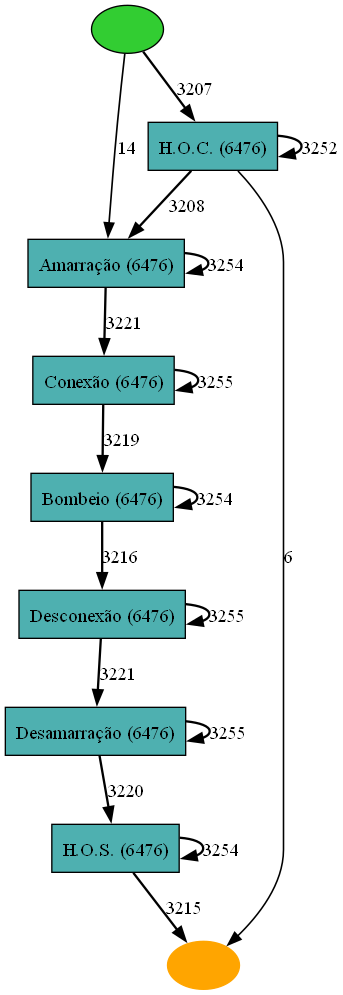

In [217]:
import pandas as pd
import pm4py

if __name__ == "__main__":
    # Lê o arquivo xlsx que contém o log de eventos
    log = pd.read_excel('c:\\Users\\caiobarreto\\Downloads\\teste.xlsx')

    # Descobre a rede heurística a partir do log de eventos.
    # A rede heurística é uma representação gráfica de relações entre atividades comuns no log.
    log['ID'] = log['ID'].astype(str)
    heuristics_net = pm4py.discover_heuristics_net(log, case_id_key='ID',activity_key='Ocorrência', timestamp_key='Início')

    # Exibe a rede heurística.
    # Isso permite visualizar as relações entre atividades no log de eventos.
    pm4py.view_heuristics_net(heuristics_net)

Process Map DFG-based (Duração)

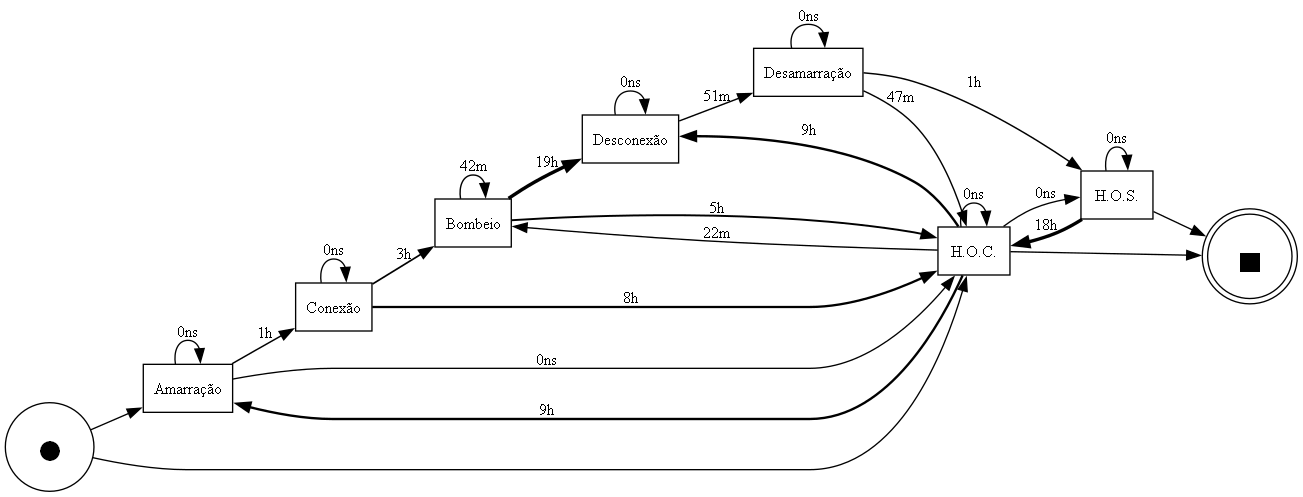

In [218]:
import pm4py

if __name__ == "__main__":
    #Lê o arquivo xlsx que contém o log de eventos
    log = pd.read_excel('c:\\Users\\caiobarreto\\Downloads\\teste.xlsx')
    log['ID'] = log['ID'].astype(str)
    performance_dfg, start_activities, end_activities = pm4py.discover_performance_dfg(log, case_id_key='ID', activity_key='Ocorrência', timestamp_key='Início')
    pm4py.view_performance_dfg(performance_dfg, start_activities, end_activities)

In [219]:
# Convertendo as colunas 'Inicio' e 'Termino' para o formato datetime
log['Início'] = pd.to_datetime(log['Início'])
log['Término'] = pd.to_datetime(log['Término'])

# Calculando a duração total e adicionando uma nova coluna 'Duração'
log['Duração'] = (log['Término'] - log['Início'])

log

,ID,Unidade Operativa,UEP,Navio,Volume Programado,Volume Retirado,Viagem,Destino,Data Prevista de Chegada,Data Prevista de Saída,Ocorrência,Início,Término,TIPO_INTERRUPCAO,DURACAO_INTERRUPCAO,INICIO_INTERRUPCAO,FIM_INTERRUPCAO,start_timestamp,Duração
0,0,UN-BS,P- 67,FORTALEZA KNUTSEN,80000,81382.81,423 TA,T.B.N.,2022-04-27 12:00:00,2022-04-28 09:30:00,H.O.C.,2022-04-27 03:00:00,2022-04-27 09:04:00,NaN,NaN,NaT,NaT,2022-04-27 03:00:00,0 days 06:04:00
1,0,UN-BS,P- 67,FORTALEZA KNUTSEN,80000,81382.81,423 TA,T.B.N.,2022-04-27 12:00:00,2022-04-28 09:30:00,H.O.C.,2022-04-27 03:00:00,2022-04-27 09:04:00,NaN,NaN,NaT,NaT,2022-04-27 03:00:00,0 days 06:04:00
2,0,UN-BS,P- 67,FORTALEZA KNUTSEN,80000,81382.81,423 TA,T.B.N.,2022-04-27 12:00:00,2022-04-28 09:30:00,Amarração,2022-04-27 09:04:00,2022-04-27 09:35:00,NaN,NaN,NaT,NaT,2022-04-27 09:04:00,0 days 00:31:00
3,0,UN-BS,P- 67,FORTALEZA KNUTSEN,80000,81382.81,423 TA,T.B.N.,2022-04-27 12:00:00,2022-04-28 09:30:00,Amarração,2022-04-27 09:04:00,2022-04-27 09:35:00,NaN,NaN,NaT,NaT,2022-04-27 09:04:00,0 days 00:31:00
4,0,UN-BS,P- 67,FORTALEZA KNUTSEN,80000,81382.81,423 TA,T.B.N.,2022-04-27 12:00:00,2022-04-28 09:30:00,Conexão,2022-04-27 09:40:00,2022-04-27 10:11:00,NaN,NaN,NaT,NaT,2022-04-27 09:40:00,0 days 00:31:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45327,3225,UN-BUZ,P- 76,ELKA LEBLON,80000,81372.15,402 TA,T.B.N.,2023-07-31 13:00:00,2023-08-01 18:00:00,Desconexão,2023-08-01 14:48:00,2023-08-01 15:36:00,NaN,NaN,NaT,NaT,2023-08-01 14:48:00,0 days 00:48:00
45328,3225,UN-BUZ,P- 76,ELKA LEBLON,80000,81372.15,402 TA,T.B.N.,2023-07-31 13:00:00,2023-08-01 18:00:00,Desamarração,2023-08-01 15:37:00,2023-08-01 16:12:00,NaN,NaN,NaT,NaT,2023-08-01 15:37:00,0 days 00:35:00
45329,3225,UN-BUZ,P- 76,ELKA LEBLON,80000,81372.15,402 TA,T.B.N.,2023-07-31 13:00:00,2023-08-01 18:00:00,Desamarração,2023-08-01 15:37:00,2023-08-01 16:12:00,NaN,NaN,NaT,NaT,2023-08-01 15:37:00,0 days 00:35:00
45330,3225,UN-BUZ,P- 76,ELKA LEBLON,80000,81372.15,402 TA,T.B.N.,2023-07-31 13:00:00,2023-08-01 18:00:00,H.O.S.,2023-08-01 18:00:00,2023-08-01 18:00:00,NaN,NaN,NaT,NaT,2023-08-01 18:00:00,0 days 00:00:00
